# Daniel's PhD
**Robust estimation of solar wind statistics**

7-8 months left to get new results; then will focus on writing (hand-in July 2025)

----

Data gaps are a perennial issue for space missions measuring the solar wind. Telemetry and instrumentation limitations together result in variably sparse time series of the interplanetary magnetic field. This is a problem for when we try and use that data to forecast space weather events (Kataoka2021, Smith2022), to analyse the coupling of the solar wind with magnetospheres (Azari, Magrini, Lockwood), and to calculate statistics of turbulence over a sufficient range of scales in order to fully probe the physics of the energy cascade (Fraternale, Gallana, Cuesta). It is this effect of gaps on this latter task that we are focussed on. Firstly, we need to define our two key turbulence statistics: the power spectrum and the structure function.

>*Quick definition of PSD, SF, ACF, and their turbulence interpretations*
 
>Structure functions = statistical moments of increments:
>$$S_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$
>For a self-similar process, $$S_p(\tau) \propto \tau^{\alpha(p)}$$ We compare power-law scaling with theoretical predictions, including calculating them for different orientations to investigate anistropy.

Small gaps (on the order of a few %) generally have a negligible effect on these statistics, and don't even require any interpolation for structure functions (power spectra do, and typically people do simple linear interpolation). Big gaps are thought to be a problem, and so these are avoided. However, this can mean throwing away lots of data, especially for very sparse datasets like Voyager. Noting the scientific value in these datasets, Fraternale tackled the problem head-on and came up with a few methods of restoring accurate slopes of spectra for large gaps, including compressed sensing and linear interpolation combined with the Blackman-Tukey method. Meanwhile, for the structure function, Burger claims that even really big gaps are fine for sparse time series such as Voyager (2023) and ACE and IMP (2022), with regards to the change in derived statistics as such as the slope. In the context of light curve analysis of blazars, Emmanoulopoulos instead showed that contrary to popular belief, gaps probably aren't fine. However, he only showed this qualitatively, and simply stated that extensive simulation was necessary to understand the systematic bias introduced by gaps and the resultant uncertainty. 

>***RESEARCH AVENUE #1*. Therefore, I am investigating the conflicting reports on structure function degradation from gaps by simulating a large variety of "mixture" sparsity on real solar wind measurements, and investigating the robustness and/or bias offered by different estimators and linear interpolation.** *STATUS: in progress; preliminary work developed during Master's published.* During my Master's I showed limited ability of ANNs to predict SFs (refined, written and published during the first 6 months of my thesis, so unsure if this will be able to go in the results or just the background section of my thesis). The advantage of the de-biasing approach being attempted currently is that it is more transparent than the black-box computation of neural networks. In both cases, I have been evaluating the performance in terms of matching the original structure function, rather than the fitted slope, which is how Fraternale and Burger estimated performance (but in the latter case with no reported visual inspection of the structure functions). I may want to add this to compare with these results.

Perhaps developing better interpolation techniques might be useful, given the unrealistic smoothing effects of linear and spline interpolation. Indeed, this probably is the best approach to gaps for the first two types of solar wind analyses: forecasting and correlation studies. Techniques such as Gaussian process regression use the correlation structure of the data to provide predictions and corresponding uncertainties for unobserved times, and has been used successfully for interpolating gaps in the MAVEN dataset to understand coupling of the solar wind with the Martian magnetosphere (Azari2023). Recently, sophisticated extensions of this technique have made these interpolants much more realistic with regards to the non-Gaussian, intermittent behaviour of the solar wind, by using a locally varying covariance constructed according to Kolmogorov's log-normal theory of intermittency (Lubke2023).

However, in the case of turbulence analysis, it is precisely the correlation structure, or more precisely, the distribution of energy across different scales, that we are interested in quantifying. If we use the correlation structure to fill gaps, even if it is realistic, we are simply feeding back into the statistics what we already know. In light of this, power spectrum work (Frat & Gallana) and SF work (de-biasing and ANNs) have stuck with either no interpolation or simple linear interpolation, which we may be able to correct for.

>***RESEARCH AVENUE #2*. Another problem when it comes to robust estimation of solar wind parameters is that of defining the Reynolds number. While it is well-defined for a collisional fluid, the only weakly collisional nature of the solar wind makes it ambiguous. By using decades of data from Wind, we can compare three definitions (including using a recently developed correction factor) and see whether they are consistent in their estimation of this important parameter.** (This is not directly related to the problem of missing data, but I thought could still be broadly described as investigating "robust statistical estimation", and therefore be included under this umbrella in my thesis. This work also led to the development of a very large statistical dataset that was only briefly analysed for this project, and therefore leads to next potential research avenue to add to my thesis, if I need one...) *STATUS: published*

>***RESEARCH AVENUE #3*. Given the large dataset I have compiled, we can further compare which solar wind parameters are more robust to missing data, and whether data mining can reveal any previously unknown relationships between various parameters. Dimensionality reduction may prove fruitful in finding the variables that explain the most variability in this complex, dynamic system.** *STATUS: not started, but preliminary correlation studies done by undergrads*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.sf_funcs as sf
import pickle

plt.rcParams.update({"font.size": 12})

# Set seed for reproducibility
np.random.seed(42)

## Load in the data
A magnetic field time series from PSP, already processed into Pandas DataFrame format

In [2]:
df_raw_full = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
df_raw = df_raw_full["B_R"]
df_raw.head()

Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64

Optionally, check the data for missing data and its frequency, get summary stats

In [3]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###

510 missing points
Length of interval: 7522952
Duration of interval: 0 days 17:59:59.987519872
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = nan
Standard deviation = nan


## Standardise each interval 
to contain 8 correlation times `tc`. Start with *approximately* 15 correlation times across 75,000 points, then calculate correlation time and use this value to down-sample to 8 correlation times across 10,000 points.

In [4]:
# Original freq is 0.007s. Resampling to less rapid but still sufficiently high cadence, then splitting into chunks with ~15 correlation times

tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

# We have approximately 15 correlation times in 10,000 points. Let's now be more precise, and calculate the correlation time from each chunk

# Split df into subsets
interval_list_approx = [
    df[i : i + interval_length_approx]
    for i in range(0, len(df) - interval_length_approx + 1, int(interval_length_approx))
]

del df  # free up memory

tc_list = []

for interval_approx in interval_list_approx:
    time_lags_lr, r_vec_lr = utils.compute_nd_acf(
        [interval_approx],
        nlags=10000,
        plot=False,
    )

    tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

    if tc == -1:
        tc = 500
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce not found for this chunk, setting to 500s (default) -> cadence = {new_cadence}s"
        )

    else:
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tce across {interval_length} points)"
        )

    tc_list.append(tc)

    interval_approx_resampled = interval_approx.resample(
        str(new_cadence) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        int_norm = utils.normalize(interval)
        good_inputs_list.append(int_norm)

print(
    "\nNumber of standardised intervals: "
    + str(len(good_inputs_list))
    + "\n(may be more than one per original chunk for small cadences)"
)

tce calculated to be 472.44s -> cadence = 0.94s (for 8tce across 4000 points)
tce calculated to be 519.81s -> cadence = 1.04s (for 8tce across 4000 points)
tce calculated to be 724.28s -> cadence = 1.45s (for 8tce across 4000 points)
tce calculated to be 612.58s -> cadence = 1.23s (for 8tce across 4000 points)
tce calculated to be 144.56s -> cadence = 0.29s (for 8tce across 4000 points)
tce calculated to be 181.96s -> cadence = 0.36s (for 8tce across 4000 points)
tce calculated to be 860.62s -> cadence = 1.72s (for 8tce across 4000 points)
tce calculated to be 444.52s -> cadence = 0.89s (for 8tce across 4000 points)

Number of standardised intervals: 18
(may be more than one per original chunk for small cadences)


In [5]:
interval_list_approx[-1].index[-1]

Timestamp('2018-11-02 16:41:09', freq='100L')

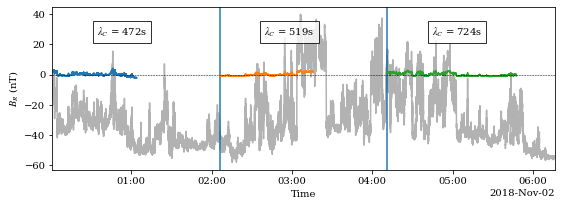

In [6]:
plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(9, 3))
[plt.plot(interval, alpha=0.3, c="black") for interval in interval_list_approx[:3]]
[plt.axvline(interval.index[-1]) for interval in interval_list_approx[:2]]
[plt.plot(interval) for interval in good_inputs_list[:3]]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
for index, tc in enumerate(tc_list[:3]):
    plt.text(
        x=interval_list_approx[index].index[0] + pd.Timedelta(seconds=2000),
        y=26,
        s=f"$\lambda_C$ = {int(tc)}s",
        bbox=dict(facecolor="white", alpha=0.8),
    )
# plt.suptitle(
#     f"Standardised solar wind time series: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$)",
#     fontsize=15,
# )
# # Add subtitle
# plt.title("Started with intervals $\sim$ 15$\lambda_C$ before refining", fontsize=12)

ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

plt.savefig("plots/int_standardised_demo.png")

In [7]:
def get_lag_vals_list(df):
    lag_vals_wide = pd.DataFrame(df["sq_diffs"].tolist(), index=df.index)
    lag_vals_wide.reset_index(inplace=True)  # Make the index a column
    lag_vals_wide.rename(columns={"index": "lag"}, inplace=True)
    lag_vals = pd.melt(
        lag_vals_wide, id_vars=["lag"], var_name="index", value_name="sq_diffs"
    )
    return lag_vals

c:\Users\spann\Documents\Research\Code repos\time_series_analysis\Kea\Kea\utils\funcs.py:142: RuntimeWarning: divide by zero encountered in reciprocal
  pl = (xx/bb)**(-a1) * (0.5 * (1. + (xx/bb)**(1./delta)))**((a1 - a2)*delta)


[[<matplotlib.lines.Line2D at 0x178214bad40>],

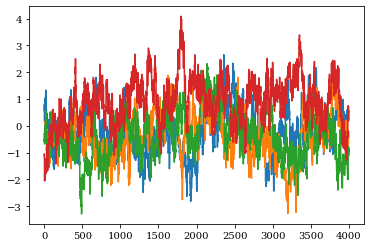

In [8]:
# SIMULATE FBM FIELD FOR PLOTTING VARIOGRAM CLOUDS, AS WELL AS PDP DATA

from Kea.Kea.simulator import fbm as fbm
import random as random

N = 4000
D = 1
L = N

# 1. Specifying Hurst parameter (using fbm package)

# for H in [0.25, 0.5, 0.75]:
#     fbm_generator = FBM(n=N, hurst=H, length=L, method="daviesharte")
#     process = fbm_generator.fbm()
#     plt.plot(process, label=f"H = {H}")
# plt.title("fBm with different Hurst parameters")
# plt.legend()
# plt.show()

# 2. Specifying power-law/s (using Mark's Kea package)

dk = 2.0 * np.pi / L
BREAK = 100.0 * dk

random.seed(42)
# Repeat the below 4 times
x_periodic = fbm.create_fbm(
    grid_dims=[4 * N for _ in range(D)],
    phys_dims=[L for _ in range(D)],
    alphas=(-1.0, -5.0 / 3.0),
    gfunc="smooth_pow",
    func_kwargs={"breaks": (BREAK,), "delta": 0.25},
)

# x = x_periodic[:N]  # removing periodicities inherent in complete field
fbm_fields = [(x_periodic[i * N : (i + 1) * N]) for i in range(4)]
[plt.plot(fbm_fields[i]) for i in range(len(fbm_fields))]

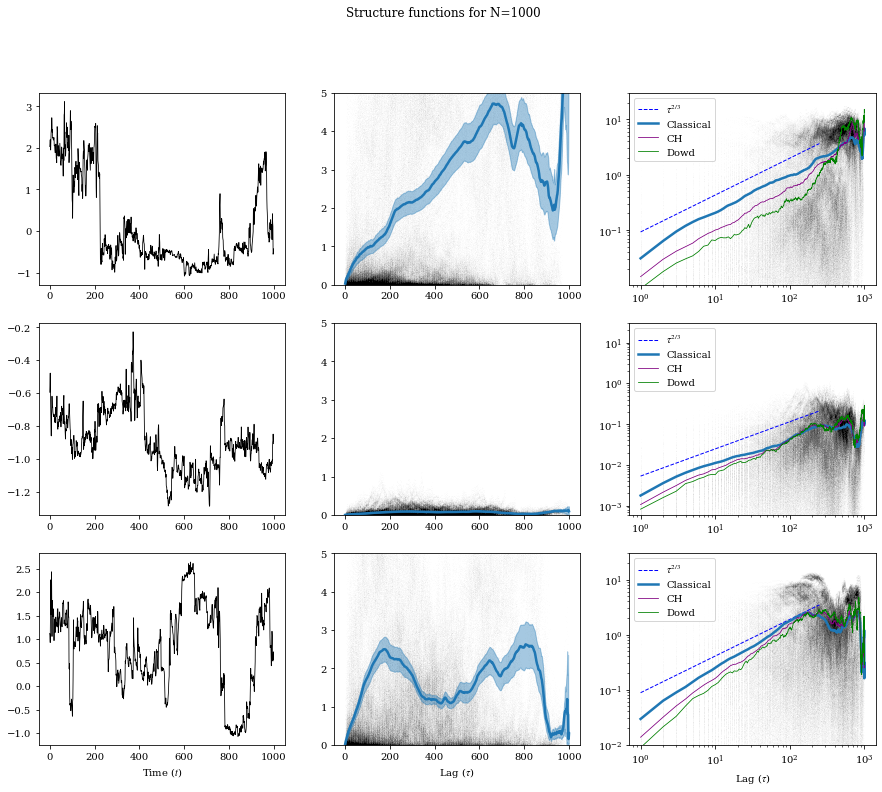

In [9]:
# WHEN CHANGING SAMPLE SIZE: change max lag and transparency too
# WHEN GOING TO -INTS FOR PSP: change ylim from 15 to 5

dt = 1
n = 1000  # sample size
n_ints = 3
fig, ax = plt.subplots(n_ints, 3, figsize=(15, 4 * n_ints))
for i, interval in enumerate(
    good_inputs_list[:n_ints]
):  # fbm_fields or good_inputs_list
    x = interval[:n]

    # Compute the structure function
    lags = np.arange(1, len(x))  # prev 0.25
    lag_times = lags * dt
    powers = [0.5, 2]

    good_output = sf.compute_sf(pd.DataFrame(x), lags, powers, retain_increments=True)

    good_output["ch_numerator"] = good_output["0.5_mean"] ** 4
    good_output["ch"] = good_output["ch_numerator"] / (
        0.457 + (0.494 / good_output["n"]) + (0.045 / good_output["n"] ** 2)
    )
    # Final part of original correction is so small as to be neglibile, hence why often left out
    # Down-weights outliers - recommended to use both
    good_output["dowd"] = (good_output["mapd"] ** 2) * 2.198

    lag_vals = get_lag_vals_list(good_output)

    ax[i, 0].plot(np.arange(0, len(x)), x, c="black", lw=0.8)

    # ax.scatter(lag_vals["lag"], lag_vals["sq_diffs"], alpha=0.005, s=0.5, c="black")
    # Plot a 2/3 power law, with the first point at the minimum of the classical structure function
    ax[i, 2].plot(
        lag_times[: int(len(lag_times) / 4)],
        3
        * good_output["classical"][1]
        * lag_times[: int(len(lag_times) / 4)] ** (2 / 3),
        label=r"$\tau^{2/3}$",
        lw=1,
        c="blue",
        ls="--",
    )
    ax[i, 1].plot(
        lag_times, good_output["classical"], label="Classical", lw=2.5, c="C0"
    )
    ax[i, 2].plot(
        lag_times, good_output["classical"], label="Classical", lw=2.5, c="C0"
    )
    ax[i, 2].plot(lag_times, good_output["ch"], label="CH", lw=0.8, c="purple")
    ax[i, 2].plot(lag_times, good_output["dowd"], label="Dowd", lw=0.8, c="green")

    # lag_vals = sf.get_lag_vals_list(good_output)
    ax[i, 1].scatter(
        lag_vals["lag"] * dt,
        lag_vals["sq_diffs"],
        # 0.3 and 0.00001 for 4000 points, 1 for 1000
        alpha=1,
        s=0.00001,
        c="black",
    )

    x = 3  # Number of standard errors to plot
    ax[i, 1].fill_between(
        good_output["lag"],
        np.maximum(
            good_output["classical"] - x * good_output["classical_se"],
            0,
        ),
        good_output["classical"] + x * good_output["classical_se"],
        color="C0",
        alpha=0.4,
        label=f"$\pm$ {x} SE",
    )

    ax[i, 2].scatter(
        lag_vals["lag"] * dt,
        lag_vals["sq_diffs"],
        alpha=1,
        s=0.00001,
        c="black",
    )

    # plt.ylim(0, 300)
    ax[n_ints - 1, 0].set_xlabel(r"Time ($t$)")
    ax[n_ints - 1, 1].set_xlabel(r"Lag ($\tau$)")
    ax[n_ints - 1, 2].set_xlabel(r"Lag ($\tau$)")
    ax[i, 2].semilogx()
    ax[i, 2].semilogy()
    ax[i, 1].set_ylim(0, 5)
    ax[i, 2].set_ylim(
        good_output["classical"].min() / 3,
        30,
        # good_output["classical"].max() * 10
    )  # log-space: *5
    ax[i, 2].legend(loc="upper left")

fig.suptitle(f"Structure functions for N={n}")
# plt.savefig(f"fbm_variogram_clouds_n_{n}.png")
plt.show()

In [10]:
import importlib

importlib.reload(sf)

<module 'src.sf_funcs' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\time_series_analysis\\src\\sf_funcs.py'>

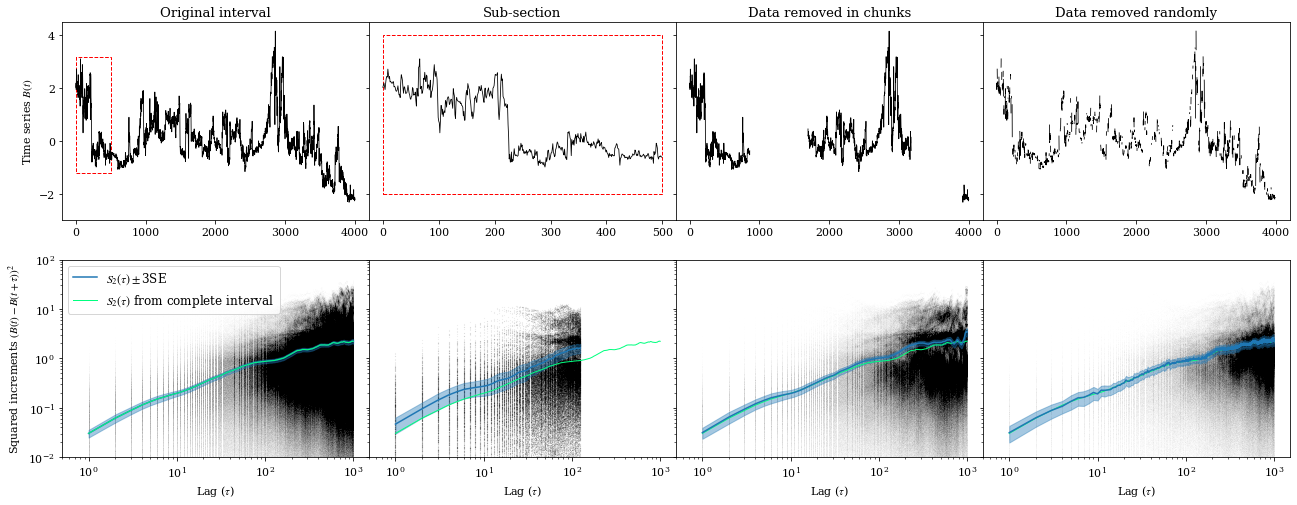

In [11]:
# WHEN CHANGING SAMPLE SIZE: change max lag and transparency too
# WHEN GOING TO -INTS FOR PSP: change ylim from 15 to 5
from matplotlib.patches import Rectangle

dt = 1
# n = 1000  # sample size
n_ints = 3
fig, ax = plt.subplots(
    2, 4, figsize=(22, 8), gridspec_kw={"hspace": 0.2, "wspace": 0}, sharey="row"
)
# Adjust spacing between subplots

x_full = good_inputs_list[0]
x_ns = x_full[0:500]
random.seed(42)
x_missing_chunks = ts.remove_data(x_full.values, 0.5, 5)[0]
x_missing_uniform = ts.remove_data(x_full.values, 0.5)[0]

alpha = [0.3, 1, 0.5, 0.5]
size = [0.00001, 0.0005, 0.00001, 0.00001]

for i, interval in enumerate([x_full, x_ns, x_missing_chunks, x_missing_uniform]):
    # interval = x_full
    # i = 0
    # x_full  # , x_ns, x_missing, x_missing_uniform
    # ):  # fbm_fields or good_inputs_list

    x = interval
    ax[0, i].plot(np.arange(0, len(x)), x, c="black", lw=0.8)

    # Compute the structure function
    lags = np.arange(1, int(0.25 * len(x)))  # prev 0.25
    lag_times = lags * dt
    powers = [0.5, 1, 2]

    good_output = sf.compute_sf(pd.DataFrame(x), lags, powers, retain_increments=True)

    lag_vals_1 = sf.get_lag_vals_list(good_output, "1_diffs")
    ax[1, i].scatter(
        lag_vals_1["lag"] * dt,
        lag_vals_1["1_diffs"],
        alpha=alpha[i],
        s=size[i],
        c="black",
    )

    lag_vals_sq = sf.get_lag_vals_list(good_output, "sq_diffs")
    ax[1, i].scatter(
        lag_vals_sq["lag"] * dt,
        lag_vals_sq["sq_diffs"],
        alpha=alpha[i],
        s=size[i],
        c="black",
    )

    ax[1, i].plot(
        lag_times, good_output["classical"], label="$S_2(\\tau)\pm$3SE", lw=1.5, c="C0"
    )
    if i == 0:
        for j in range(4):
            ax[1, j].plot(
                lag_times,
                good_output["classical"],
                label="$S_2(\\tau)$ from complete interval",
                lw=1,
                c="springgreen",
            )

    x = 3  # Number of standard errors to plot
    ax[1, i].fill_between(
        good_output["lag"],
        np.maximum(
            good_output["classical"] - x * good_output["classical_se"],
            0,
        ),
        good_output["classical"] + x * good_output["classical_se"],
        color="C0",
        alpha=0.4,
        # label=f"$\pm$ {x} SE",
    )
    ax[0, i].set_ylim(-3, 4.5)

    ax[1, i].semilogx()
    ax[1, i].semilogy()
    ax[1, i].set_xlim(5e-1, 1.5e3)
    ax[1, i].set_xlabel("Lag ($\\tau$)")
    ax[1, i].set_ylim(1e-2, 1e2)

# Add rectangle around subset
rect1 = Rectangle(
    (0, -1.2), 500, 4.4, linewidth=1, edgecolor="r", facecolor="none", linestyle="--"
)
rect2 = Rectangle(
    (0, -2), 500, 6, linewidth=1, edgecolor="r", facecolor="none", linestyle="--"
)
ax[0, 0].add_patch(rect1)
ax[0, 1].add_patch(rect2)
ax[0, 0].set_title("Original interval")
ax[0, 1].set_title("Sub-section")
ax[0, 2].set_title("Data removed in chunks")
ax[0, 3].set_title("Data removed randomly")

ax[0, 0].set_ylabel("Time series $B(t)$")
ax[1, 0].set_ylabel("Squared increments $(B(t) - B(t+\\tau))^2$")
ax[1, 0].legend(loc="upper left", fontsize=12)

# Increase matplotlib font size
plt.rcParams.update({"font.size": 14})
plt.savefig("plots/figs/psp_variogram_clouds_comprehensive.png")

plt.show()

## FBM VERSION

In [12]:
fbm_fields[0]

array([ 0.57560866,  0.79991009,  0.36981648, ..., -1.11543663,
       -0.93797234, -0.84003155])

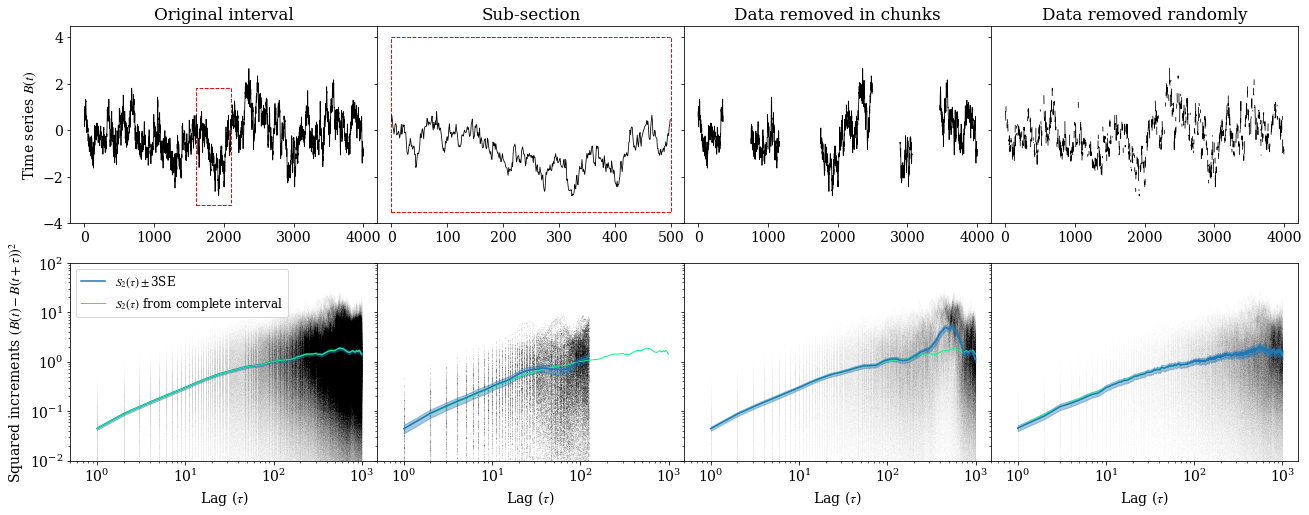

In [13]:
# WHEN CHANGING SAMPLE SIZE: change max lag and transparency too
# WHEN GOING TO -INTS FOR PSP: change ylim from 15 to 5

dt = 1
# n = 1000  # sample size
n_ints = 3
fig, ax = plt.subplots(
    2, 4, figsize=(22, 8), gridspec_kw={"hspace": 0.2, "wspace": 0}, sharey="row"
)  # Adjust spacing between subplots
x_full = pd.DataFrame(fbm_fields[0])
subset_start = 1600
subset_end = 2100
x_ns = x_full[subset_start:subset_end]
random.seed(42)
x_missing_chunks = ts.remove_data(x_full.values, 0.5, 5)[0]
x_missing_uniform = ts.remove_data(x_full.values, 0.5)[0]

alpha = [0.3, 1, 0.5, 0.5]
size = [0.00001, 0.0005, 0.00001, 0.00001]

for i, interval in enumerate([x_full, x_ns, x_missing_chunks, x_missing_uniform]):
    # interval = x_full
    # i = 0
    # x_full  # , x_ns, x_missing, x_missing_uniform
    # ):  # fbm_fields or good_inputs_list

    x = interval
    ax[0, i].plot(np.arange(0, len(x)), x, c="black", lw=0.8)

    # Compute the structure function
    lags = np.arange(1, int(0.25 * len(x)))  # prev 0.25
    lag_times = lags * dt
    powers = [0.5, 1, 2]

    good_output = sf.compute_sf(pd.DataFrame(x), lags, powers, retain_increments=True)

    lag_vals_sq = sf.get_lag_vals_list(good_output, "sq_diffs")
    ax[1, i].scatter(
        lag_vals_sq["lag"] * dt,
        lag_vals_sq["sq_diffs"],
        alpha=alpha[i],
        s=size[i],
        c="black",
    )

    ax[1, i].plot(
        lag_times, good_output["classical"], label="$S_2(\\tau)\pm$3SE", lw=1.5, c="C0"
    )
    if i == 0:
        for j in range(4):
            ax[1, j].plot(
                lag_times,
                good_output["classical"],
                label="$S_2(\\tau)$ from complete interval",
                lw=1,
                c="springgreen",
            )

    x = 3  # Number of standard errors to plot
    ax[1, i].fill_between(
        good_output["lag"],
        np.maximum(
            good_output["classical"] - x * good_output["classical_se"],
            0,
        ),
        good_output["classical"] + x * good_output["classical_se"],
        color="C0",
        alpha=0.4,
        # label=f"$\pm$ {x} SE",
    )
    ax[0, i].set_ylim(-4, 4.5)

    ax[1, i].semilogx()
    ax[1, i].semilogy()
    ax[1, i].set_xlabel("Lag ($\\tau$)")
    ax[1, i].set_xlim(5e-1, 1.5e3)
    ax[1, i].set_ylim(1e-2, 1e2)

# Add rectangle around subset
rect1 = Rectangle(
    (subset_start, -3.2),
    subset_end - subset_start,
    5,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
    linestyle="--",
)
rect2 = Rectangle(
    (0, -3.5),
    subset_end - subset_start,
    7.5,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
    linestyle="--",
)
ax[0, 0].add_patch(rect1)
ax[0, 1].add_patch(rect2)
ax[0, 0].set_title("Original interval")
ax[0, 1].set_title("Sub-section")
ax[0, 2].set_title("Data removed in chunks")
ax[0, 3].set_title("Data removed randomly")

ax[0, 0].set_ylabel("Time series $B(t)$")
ax[1, 0].set_ylabel("Squared increments $(B(t) - B(t+\\tau))^2$")
ax[1, 0].legend(loc="upper left", fontsize=12)

# Increase matplotlib font size
plt.rcParams.update({"font.size": 14})
plt.savefig("plots/figs/fbm_variogram_clouds_comprehensive.png")

plt.show()

Mostly, we can just fit one time series of 8tc into each original one of about 2 hours. (8tc is approx 80min).

## Get gapped statistics
Remove data from each input multiple times and compute SF, naive and interpolated: **currently handled by `get_gapped_sf.py` script**

---

## Analyse and plot results

In [16]:
# Read in pickle file data/processed/list_of_list_of_dfs.pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.sf_funcs as sf
import pickle
import importlib

importlib.reload(sf)

with open("data/processed/sfs_psp_core_0.pkl", "rb") as f:
    list_of_list_of_dfs = pickle.load(f)

# Unpack the list of list of dfs
(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
) = list_of_list_of_dfs

In [17]:
print(
    f"{len(all_interp_outputs_list[0])} versions of {len(all_interp_outputs_list)} outputs"
)

5 versions of 105 outputs


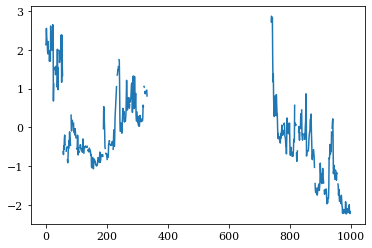

In [18]:
plt.plot(all_bad_inputs_list[0][1])

In [19]:
# Perform random train-test split
from sklearn.model_selection import train_test_split

(
    good_inputs_train,
    good_inputs_test,
    good_outputs_train,
    good_outputs_test,
    bad_inputs_train,
    bad_inputs_test,
    bad_outputs_train,
    bad_outputs_test,
    interp_inputs_train,
    interp_inputs_test,
    interp_outputs_train,
    interp_outputs_test,
) = train_test_split(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    test_size=0.2,
    random_state=42,
)
print(
    f"Number of training interval: {len(good_inputs_train)} x {len(bad_inputs_train[0])} = {len(good_inputs_train)*len(bad_inputs_train[0])}"
)
print(
    f"Number of test intervals: {len(good_inputs_test)} x {len(bad_inputs_test[0])} = {len(good_inputs_test)*len(bad_inputs_test[0])}"
)

Number of training interval: 84 x 5 = 420
Number of test intervals: 21 x 5 = 105


### Naive

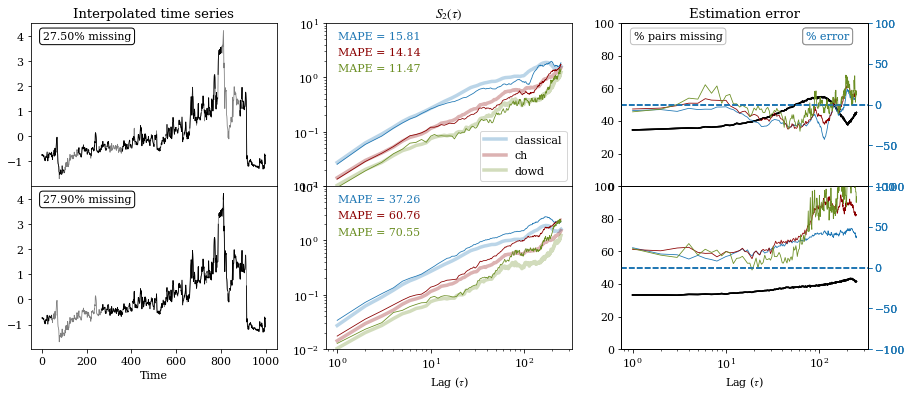

In [20]:
# Check results, for a given clean input
importlib.reload(sf)

input_ind = 15  # 8 is pretty good, 1 if using 3 bad inputs, 3 has cool spikes
n_versions_to_plot = 2

sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    bad_inputs_test,
    bad_outputs_test,
    input_ind,
    n_versions_to_plot,
    False,
    estimator_list=["classical", "ch", "dowd"],
)
plt.savefig("plots/sim_results_local/sf_i_1_naive.png")

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, reflecting the increased uncertainty of fewer *true* observations

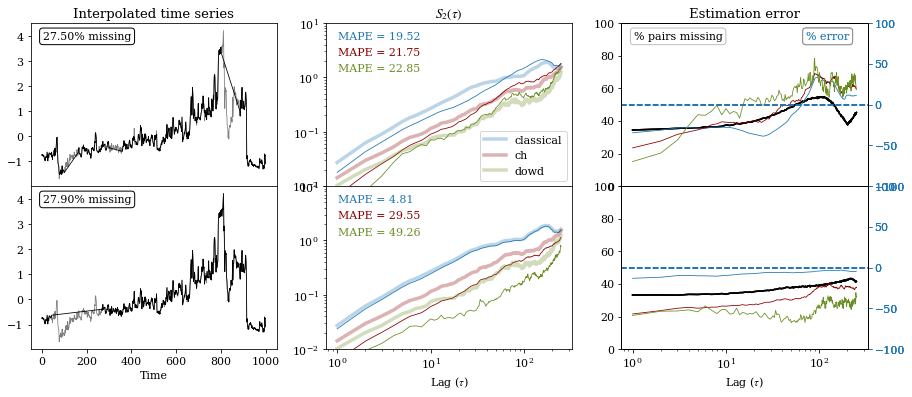

In [21]:
importlib.reload(sf)
sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    interp_inputs_test,
    interp_outputs_test,
    input_ind,
    n_versions_to_plot,
    False,
    estimator_list=["classical", "ch", "dowd"],
)
plt.savefig("plots/sim_results_local/sf_i_1_lint.png")

## Do holistic analysis of errors

In [22]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis
def concat_dfs(lst_of_list_of_dfs):
    merged_df = pd.concat(
        [pd.concat(lst, keys=range(len(lst))) for lst in lst_of_list_of_dfs],
        keys=range(len(lst_of_list_of_dfs)),
    )
    # Renaming MultiIndex levels
    merged_df.index.names = ["Original interval", "Interval version", "Lag"]
    return merged_df


bad_outputs_train_df = concat_dfs(bad_outputs_train)
interp_outputs_train_df = concat_dfs(interp_outputs_train)
bad_outputs_test_df = concat_dfs(bad_outputs_test)
interp_outputs_test_df = concat_dfs(interp_outputs_test)

In [23]:
bad_outputs_train_df.columns

Index(['n', '0.5_mean', '0.5_std', '0.5_std_err', 'lag', 'classical', 'mapd',
       'classical_se', 'ch', 'dowd', 'missing_prop', 'classical_error',
       'classical_error_percent', 'ch_error', 'ch_error_percent', 'dowd_error',
       'dowd_error_percent', 'missing_prop_overall', 'lint'],
      dtype='object')

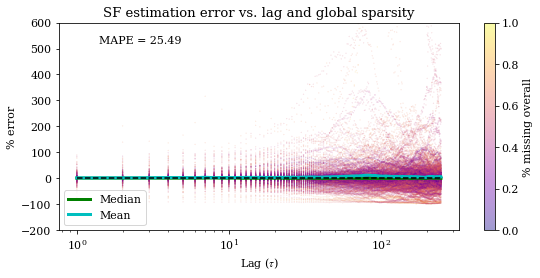

In [24]:
importlib.reload(sf)
# View trends as fn of OVERALL missing amount
sf.plot_error_trend_line(bad_outputs_train_df, estimator="ch", y_axis_log=False)
# plt.savefig("plots/psp_missing_effect_holistic.png")

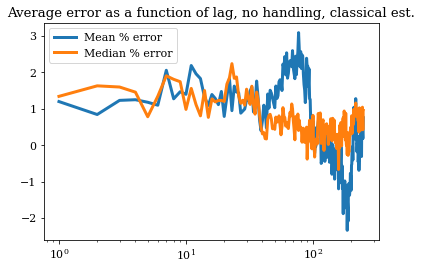

In [25]:
def plot_average_errors(df):
    stats = df.groupby("Lag")["classical_error_percent"].describe()
    plt.plot(stats["mean"], lw=3, label="Mean % error")
    plt.plot(stats["50%"], lw=3, label="Median % error")
    plt.semilogx()
    plt.legend()
    plt.title("Average error as a function of lag, no handling, classical est.")


plot_average_errors(bad_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_avg.png")

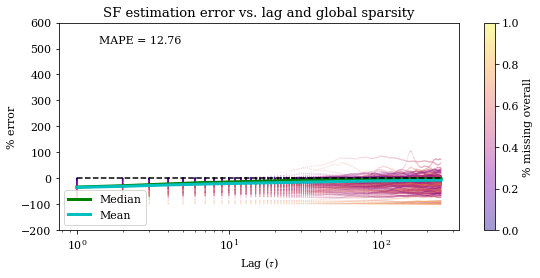

In [26]:
sf.plot_error_trend_line(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint.png")

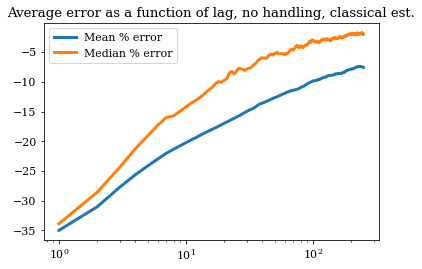

In [27]:
plot_average_errors(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint_avg.png")

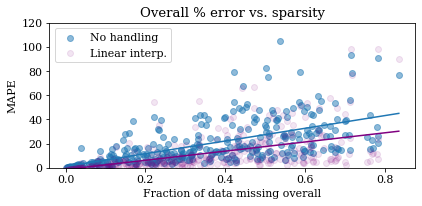

In [28]:
sf.plot_error_trend_scatter(bad_outputs_train_df, interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_scatter.png")

In [29]:
# Investigating weird spikes at small lag
interp_outputs_train_df.sort_values("classical_error_percent", ascending=False).head(5)

n  0.5_mean   0.5_std  \
Original interval Interval version Lag                              
71                2                157.0  843  0.992558  0.496777   
                                   158.0  842  0.995754  0.496831   
                                   156.0  844  0.989568  0.496744   
                                   159.0  841  0.998369  0.497107   
                                   155.0  845  0.990663  0.492009   

                                          0.5_std_err    lag  classical  \
Original interval Interval version Lag                                    
71                2                157.0     0.017110  157.0   2.892152   
                                   158.0     0.017122  158.0   2.911624   
                                   156.0     0.017099  156.0   2.872754   
                                   159.0     0.017142  159.0   2.928268   
                                   155.0     0.016926  155.0   2.856618   

                                              mapd  classical_se        ch  \
Original interval Interval version Lag                                       
71                2                157.0  1.083926      0.561177  2.121053   
                                   158.0  1.090830      0.573834  2.148496   
                                   156.0  1.077022      0.543940  2.095608   
                                   159.0  1.097734      0.580760  2.171154   
                                   155.0  1.070118      0.533553  2.104905   

                                              dowd  missing_prop  \
Original interval Interval version Lag                             
71                2                157.0  2.582419      0.767497   
                                   158.0  2.615421      0.769596   
                                   156.0  2.549627      0.763033   
                                   159.0  2.648632      0.770511   
                                   155.0  2.517044      0.760947   

                                          classical_error  \
Original interval Interval version Lag                      
71                2                157.0         1.473541   
                                   158.0         1.481159   
                                   156.0         1.458947   
                                   159.0         1.485021   
                                   155.0         1.427880   

                                          classical_error_percent  ch_error  \
Original interval Interval version Lag                                        
71                2                157.0               103.872139  1.024504   
                                   158.0               103.543912  1.059991   
                                   156.0               103.192753  1.008816   
                                   159.0               102.894438  1.118131   
                                   155.0                99.939887  1.002305   

                                          ch_error_percent  dowd_error  \
Original interval Interval version Lag                                   
71                2                157.0         93.429828    1.550772   
                                   158.0         97.380450    1.608185   
                                   156.0         92.825065    1.545602   
                                   159.0        106.183014    1.629390   
                                   155.0         90.903751    1.556244   

                                          dowd_error_percent  \
Original interval Interval version Lag                         
71                2                157.0          150.320093   
                                   158.0          159.663046   
                                   156.0          153.940561   
                                   159.0          159.862832   
                                   155.0          161.973704   

                                          missing_prop_overa

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

In [30]:
missing_measure = "missing_prop"
n_bins = 15

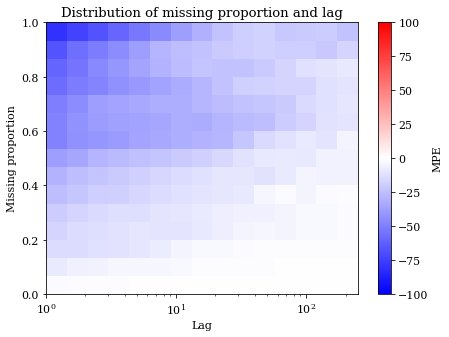

In [31]:
heatmap_bin_vals, heatmap_bin_edges, lookup_table = sf.create_heatmap_lookup(
    interp_outputs_train_df, missing_measure, n_bins, log=True
)

# If wanting linear bins, can then simply use the following:

# axs = sf.plot_heatmap(
#     heatmap_bin_vals,
#     heatmap_bin_edges,
#     "Missing proportion",
#     False,
# )

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges[0],
    heatmap_bin_edges[1],
    heatmap_bin_vals.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
ax.set_facecolor("black")
ax.set_xscale("log")
# plt.savefig(f"plots/psp_correction_heatmap_{n_bins}_bins.png")

Check out sample size in each bin (above just shows where there is no data with black bins).
Below 2D histogram is not working for log bins, for some reason

Text(0.5, 1.0, 'Distribution of missing proportion and lag')

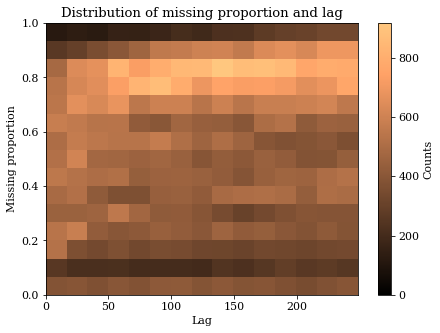

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
hb = ax.hist2d(
    interp_outputs_train_df["lag"],
    interp_outputs_train_df[missing_measure],
    bins=n_bins,
    cmap="copper",
    range=[[0, interp_outputs_train_df.lag.max()], [0, 1]],
)
plt.colorbar(hb[3], ax=ax, label="Counts")
hb[3].set_clim(0, hb[0].max())
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
# plt.savefig("plots/psp_heatmap_sample_size.png")

In [33]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(interp_outputs_train_df, missing_measure, n_bins, True)
)

## Apply empirical correction factor to bad SFs

*Regardless of whether I save to it again, `interp_outputs_test_df` is edited within the function each time, which is fine by me.*

In [34]:
def compute_scaling_new(bad_output, var, heatmap_vals):
    """
    Extracting values from each bin to create a look-up table. Note that due to binning we have to find the nearest value to get the corresponding MAPE for a given lag and proportion of pairs remaining. Using MPE as we want to maintaing the direction of the error for compensating."""
    df = heatmap_vals.copy()

    # Precompute scaling factors
    df["scaling"] = 1 / (1 + df["MPE"] / 100)
    df["scaling_lower"] = 1 / (1 + (df["MPE"] + 2 * df["MPE_std_err"]) / 100)
    df["scaling_upper"] = 1 / (1 + (df["MPE"] - 2 * df["MPE_std_err"]) / 100)

    # If no nearest bin is found (len(nearest_row)=0), scaling will be 1 (the same)
    bad_output["scaling"] = 1
    bad_output["scaling_lower"] = 1
    bad_output["scaling_upper"] = 1

    for i, row in bad_output.iterrows():
        desired_prop = row[var]
        desired_lag = i[2]  # 3rd level of multi-index = lag

        # Compute absolute differences
        lag_diff = np.abs(df["Lag"] - desired_lag)
        prop_diff = np.abs(df[var] - desired_prop)

        # Find the nearest row
        min_lag_diff = lag_diff.min()
        min_prop_diff = prop_diff.min()
        nearest_row = df.loc[(lag_diff == min_lag_diff) & (prop_diff == min_prop_diff)]

        if len(nearest_row) > 1:
            result = nearest_row.head(1)
        else:
            result = nearest_row.head(1)
            scaling = result["scaling"].values[0]
            scaling_lower = result["scaling_lower"].values[0]
            scaling_upper = result["scaling_upper"].values[0]

        bad_output.at[i, "scaling"] = scaling
        bad_output.at[i, "scaling_lower"] = scaling_lower
        bad_output.at[i, "scaling_upper"] = scaling_upper

    bad_output.loc[bad_output["classical_error"] == 0, "scaling"] = (
        1  # Catching 0 errors
    )

    bad_output["classical_corrected"] = bad_output["classical"] * bad_output["scaling"]
    bad_output["classical_corrected_lower"] = (
        bad_output["classical"] * bad_output["scaling_lower"]
    )
    bad_output["classical_corrected_upper"] = (
        bad_output["classical"] * bad_output["scaling_upper"]
    )
    print("finished correction, now smoothing")
    # Smoothing potentially jumpy correction
    # bad_output["scaling_smoothed"] = (
    #     bad_output["scaling"].rolling(window=20, min_periods=1).mean()
    # )
    # bad_output["classical_corrected_smoothed"] = (
    #     bad_output["classical"] * bad_output["scaling_smoothed"]
    # )
    print("finished smoothing, now next interval")
    return bad_output

In [35]:
interp_outputs_test_df = sf.compute_scaling(
    interp_outputs_test_df, missing_measure, lookup_table
)

In [36]:
interp_outputs_test_df = sf.compute_scaling_3d(
    interp_outputs_test_df, missing_measure, lookup_table_3d
)

In [38]:
print(
    "Mean MAPE of interpolated intervals in test set = {:.2f}".format(
        interp_outputs_test_df["classical_error_percent"].abs().mean()
    )
)

# Calculate corrected test set error
error_percents_2d = []
error_percents_3d = []
times_to_gap = 2

for i, df in enumerate(good_outputs_test):
    for j in range(times_to_gap):
        # Calculate difference
        error_2d = (
            interp_outputs_test_df.loc[(i, j), "classical_corrected"] - df["classical"]
        )
        error_percent_2d = error_2d / df["classical"] * 100
        error_percents_2d.append(error_percent_2d)

        error_3d = (
            interp_outputs_test_df.loc[(i, j), "classical_corrected_3d"]
            - df["classical"]
        )
        error_percent_3d = error_3d / df["classical"] * 100
        error_percents_3d.append(error_percent_3d)

print(
    "Mean MAPE of corrected (2D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_2d))
    )
)
print(
    "Mean MAPE of corrected (3D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_3d))
    )
)

Mean MAPE of interpolated intervals in test set = 14.65
Mean MAPE of corrected (2D) interpolated intervals test set = 13.23
Mean MAPE of corrected (3D) interpolated intervals test set = 15.43


In [39]:
interp_outputs_test_df.loc[0, 1]["classical_error_percent"].abs().mean()

30.524371734784307

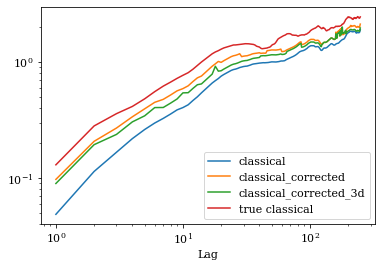

In [42]:
interp_outputs_test_df.loc[0, 1][
    [
        "classical",
        "classical_corrected",
        "classical_corrected_3d",
    ]
].plot()
good_outputs_test[0]["classical"].plot(label="true classical")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

## Using the test set, plot the same intervals originally plotted

In [ ]:
versions_ordered_sparsity = (
    interp_outputs_test_df.loc[input_ind, : n_versions_to_plot - 1, :]
    .sort_values("missing_prop_overall")
    .index.get_level_values(1)
    .unique()
    .values
)
# Extract the unique second-level indexes
for i in versions_ordered_sparsity:
    print(i)

1
0


Text(0.5, 0.98, 'Applying correction factor to interpolated SFs in test set')

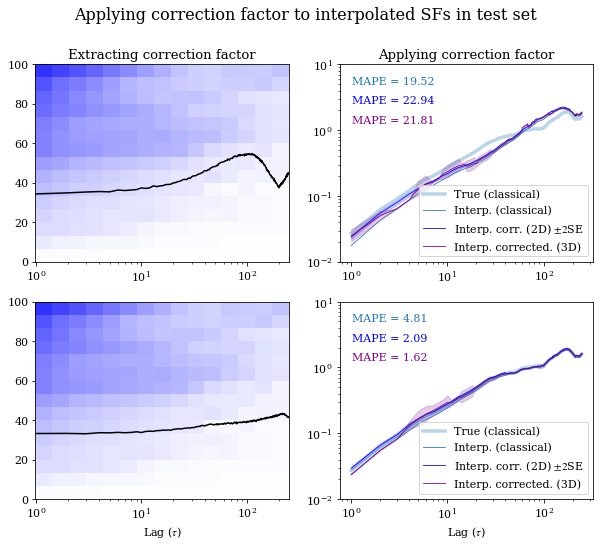

In [44]:
fig, axs = plt.subplots(n_versions_to_plot, 2, figsize=(10, 4 * n_versions_to_plot))

# Get the relevent indices in order of sparsity for better plot aesthetics
versions_ordered_sparsity = (
    interp_outputs_test_df.loc[input_ind, : n_versions_to_plot - 1, :]
    .sort_values("missing_prop_overall")
    .index.get_level_values(1)
    .unique()
    .values
)

for i, int_version in enumerate(versions_ordered_sparsity):
    mape_bad = (
        interp_outputs_test_df.loc[input_ind, int_version]["classical_error_percent"]
        .abs()
        .mean()
    )
    mape_corrected = (
        error_percents_2d[input_ind * times_to_gap + int_version].abs().mean()
    )
    mape_corrected_3d = (
        error_percents_3d[input_ind * times_to_gap + int_version].abs().mean()
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.9),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="C0",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.8),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected_3d),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.7),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="purple",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].plot(
        good_outputs_test[input_ind]["classical"],
        color="C0",
        label="True (classical)",
        lw=3.5,
        alpha=0.3,
    )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical"],
        color="C0",
        lw=0.8,
        label="Interp. (classical)",
    )
    # axs[i, 1].plot(
    #     sf_corrected["classical"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected"],
        c="blue",
        lw=0.8,
        label="Interp. corr. (2D) $\pm 2$SE",
    )
    axs[i, 1].fill_between(
        interp_outputs_test_df.loc[input_ind, int_version]["lag"],
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_lower"],
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_upper"],
        color="blue",
        alpha=0.2,
    )
    #    axs[i, 1].plot(
    #        sf_corrected["classical_corrected_smoothed"],
    #        c="orange",
    #        label="Corrected Bad Smoothed",
    #    )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_3d"],
        c="purple",
        lw=0.8,
        label="Interp. corrected. (3D)",
    )

    axs[i, 1].fill_between(
        interp_outputs_test_df.loc[input_ind, int_version]["lag"],
        interp_outputs_test_df.loc[input_ind, int_version][
            "classical_corrected_3d_lower"
        ],
        interp_outputs_test_df.loc[input_ind, int_version][
            "classical_corrected_3d_upper"
        ],
        color="purple",
        alpha=0.2,
    )

    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].set_ylim(1e-2, 1e1)
    axs[i, 1].legend(loc="lower right")

    # if log is True:
    c = axs[i, 0].pcolormesh(
        heatmap_bin_edges[0],
        heatmap_bin_edges[1] * 100,  # convert to % Missing
        heatmap_bin_vals.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=axs[i, 0], label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    # axs[i, 0].set_xlabel("Lag")
    axs[i, 0].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["lag"],
        interp_outputs_test_df.loc[input_ind, int_version][missing_measure] * 100,
        c="black",
    )

    axs[i, 0].set_xscale("log")
    axs[i, 0].set_ylim(0, 100)
    # axs[i, 0] = sf.plot_heatmap(
    #     heatmap_bin_vals_log,
    #     heatmap_bin_edges_log,
    #     missing_measure=missing_measure,
    #     log=True,
    #     overlay_x=df_to_plot["lag"],
    #     overlay_y=df_to_plot[missing_measure],
    #     subplot=axs[i, 0],
    # )
axs[0, 1].set_title("Applying correction factor")
axs[0, 0].set_title("Extracting correction factor")
axs[n_versions_to_plot - 1, 0].set_xlabel("Lag ($\\tau$)")
axs[n_versions_to_plot - 1, 1].set_xlabel("Lag ($\\tau$)")
fig.suptitle("Applying correction factor to interpolated SFs in test set", size=16)

## Plotting the 3D heatmap

In [45]:
plt.rcParams.update({"font.size": 8})

Text(0, 0.5, 'Missing proportion')

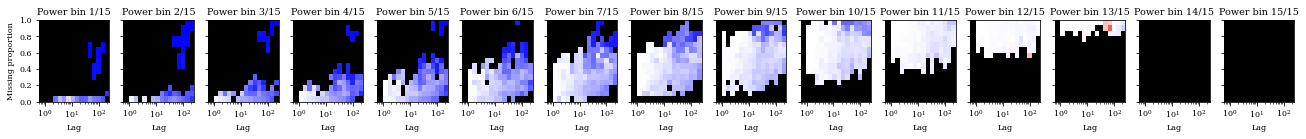

In [46]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Missing proportion")
# plt.savefig("psp_heatmap_3d_power.png")

Text(0, 0.5, 'Power')

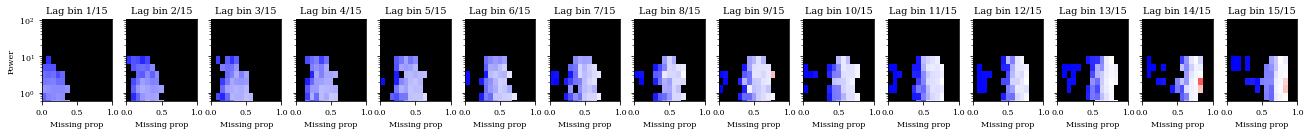

In [47]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Missing prop")
    # ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_ylim(6e-1, 105)
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_lag.png")

Text(0, 0.5, 'Power')

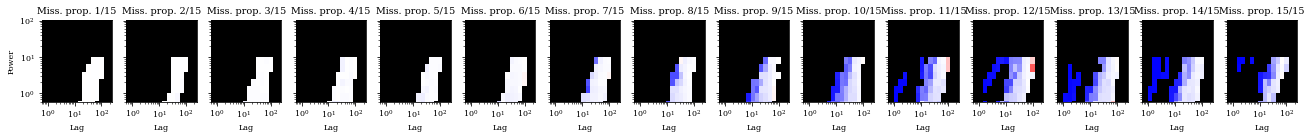

In [48]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlim(6e-1, 250)
    ax[i].set_ylim(6e-1, 105)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Miss. prop. {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_missing.png")